<a href="https://colab.research.google.com/github/aimalz/TheLastMetric/blob/master/FigureTLMvsRedshift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial downloads and installs

In [1]:
!pip install --quiet pzflow corner
!git clone https://github.com/aimalz/TheLastMetric.git
%cd TheLastMetric

     |████████████████████████████████| 7.8MB 6.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
Cloning into 'TheLastMetric'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 185 (delta 66), reused 114 (delta 24), pack-reused 0
Receiving objects: 100% (185/185), 9.47 MiB | 19.16 MiB/s, done.
Resolving deltas: 100% (66/66), done.
/content/TheLastMetric


## Imports and downloading data

In [22]:
%pylab inline
from utils import load_data
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import corner
import scipy.stats
from pzflow import Flow
from pzflow.distributions import Uniform
from pzflow.bijectors import Chain, StandardScaler, NeuralSplineCoupling

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['hist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [9]:
z_cats, phot_cats, available_os, os_names, os_colors = load_data()

## Approximating the Mutual Information Lower Bound

We use a normalizing flow to approximate the distribution of redshift and photometry.

In [10]:
flows = {}
for os in available_os:
  flows[os] = Flow(file=f"trained_flows/flow_for_run_{os}.pkl")

This plot should show the redshift posterior distribution for given photometry $q_\theta(z | x_{phot})$. 

We are going to use that to compute our lower bound on the mutual information

$$I(z; x_{phot})  \geq \mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]  + H(z)$$ 

The second term in this bound only depends on the true redshift distribution, which stays constant between observing strategies. Only the first term depends on the observed photometry, so it is the only one we have to compare between `OpSim` runs.

In [39]:
all_milb = {}
for which_os in available_os:
  phot_cat = phot_cats[which_os].to_pandas().merge(z_cats[which_os].to_pandas())
  
  # Computing the entropy H(z)
  pz = scipy.stats.rv_histogram(np.histogram(phot_cat['z_true'], bins=128, range=[0,3]))
  entropy = pz.entropy()

  # Computing lower bound
  mutual_information_lower_bound = flows[which_os].log_prob(flows[which_os].info["condition_scaler"](phot_cat)) + entropy
  all_milb[which_os] = mutual_information_lower_bound
  print((os_names[which_os], np.mean(mutual_information_lower_bound)))

('baseline_v1_5_10yrs', DeviceArray(3.1274273, dtype=float32))
('footprint_stuck_rollingv1_5_10yrs', DeviceArray(2.9430377, dtype=float32))
('ddf_heavy_nexp2_v1_6_10yrs', DeviceArray(3.0353925, dtype=float32))
('footprint_newAv1_5_10yrs', DeviceArray(3.0486393, dtype=float32))
('third_obs_pt60v1_5_10yrs', DeviceArray(3.135779, dtype=float32))
('barebones_v1_6_10yrs', DeviceArray(3.2149158, dtype=float32))


In [44]:
# Computing the metric in redshift bins
mis = {}
mis_median = {}
n = 16
b = linspace(0,2.6,n)

for which_os in available_os:
  inds = digitize(z_cats[which_os]['z_true'], b)
  res = zeros(n)
  res_med = zeros(n)
  for i in range(n):
    res[i] = mean((all_milb[which_os].flatten()[inds == i]))
    res_med[i] = median((all_milb[which_os].flatten()[inds == i]))
    
  mis[which_os] = res
  mis_median[which_os] = res_med

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


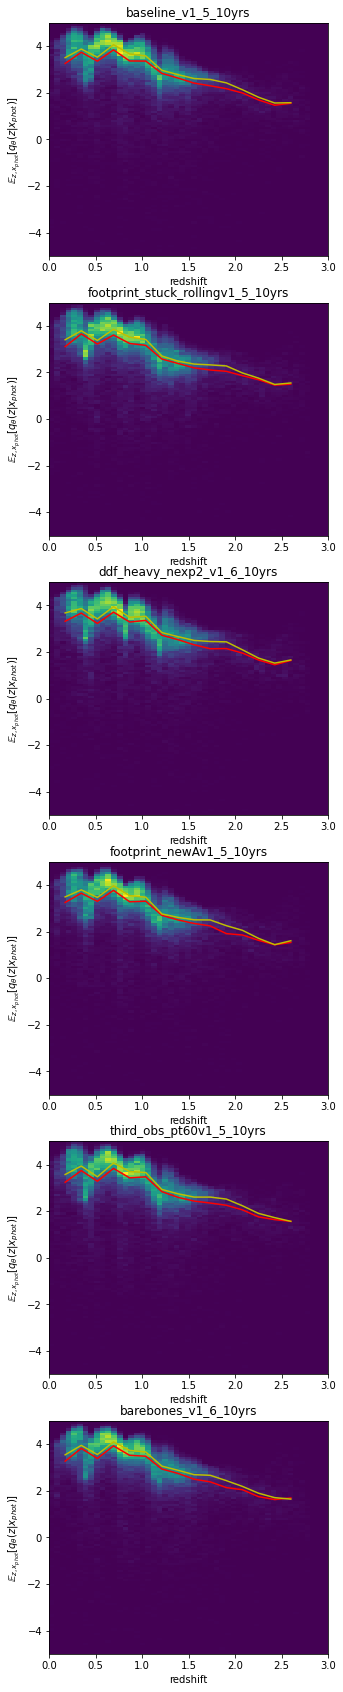

In [46]:
fig, axs = plt.subplots(len(available_os), 1, figsize=(5, 5*len(available_os)))
for i, which_os in enumerate(available_os):
  axs[i].hist2d(z_cats[which_os]['z_true'], all_milb[which_os].flatten(), bins=[np.linspace(0., 3., 50), np.linspace(-5., 5., 100)])
  axs[i].plot(b,mis[which_os], color='r')
  axs[i].plot(b,mis_median[which_os], color='y')
  axs[i].set_xlabel('redshift')
  axs[i].set_ylabel(r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
  axs[i].set_title(os_names[which_os])

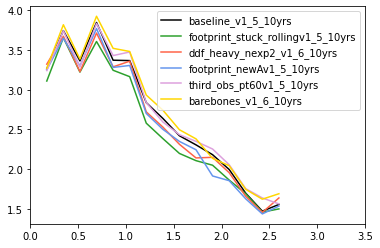

In [47]:
for which_os in available_os:
  plot(b, mis[which_os], label=os_names[which_os], color=os_colors[which_os])
  xlim(0, 3.5)
legend()

(-0.3, 0.6)

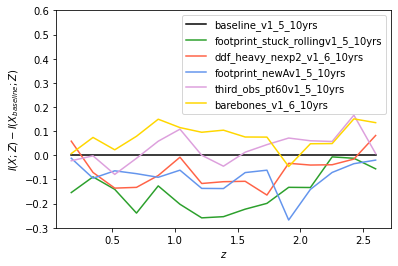

In [56]:
for which_os in available_os:
  plot(b, mis[which_os] - mis['1_4_y10'], label=os_names[which_os], color=os_colors[which_os])
legend(loc='upper right')
xlabel('$z$')
ylabel('$I(X ; Z) - I(X_{baseline} ; Z)$');
savefig('figure4.png')
ylim(-0.3,0.6)